# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [16]:
# DO NOT CHANGE

import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


In [17]:
bandit0 = BanditProblem(0)

In [18]:
bandit0.get_num_arms()

3

In [19]:
bandit0.get_reward(arm=0)

1.8255111545554434

Arm 0: mean=0.8284, std=0.8248, min=0.0000, max=6.7825, zero_rate=0.162
Arm 1: mean=0.6296, std=0.6655, min=0.0000, max=3.9734, zero_rate=0.238
Arm 2: mean=0.8914, std=0.7982, min=0.0000, max=4.7381, zero_rate=0.104


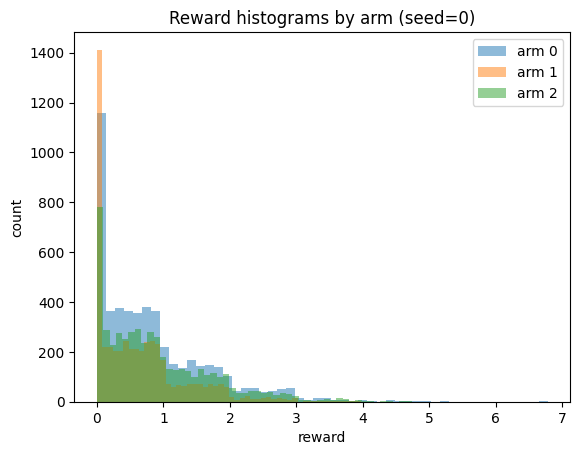

In [20]:
# YOUR CHANGES HERE
import numpy as np
import matplotlib.pyplot as plt

# Instantiate bandit with seed 0
bandit = BanditProblem(seed=0)
K = bandit.get_num_arms()

# Pull each arm many times to see reward distribution
N = 5000
samples = {a: np.array([bandit.get_reward(a) for _ in range(N)]) for a in range(K)}

# Print quick summary stats
for a in range(K):
    x = samples[a]
    print(
        f"Arm {a}: mean={x.mean():.4f}, std={x.std():.4f}, "
        f"min={x.min():.4f}, max={x.max():.4f}, zero_rate={(x==0).mean():.3f}"
    )

# Plot histograms
plt.figure()
for a in range(K):
    plt.hist(samples[a], bins=50, alpha=0.5, label=f"arm {a}")
plt.title("Reward histograms by arm (seed=0)")
plt.xlabel("reward")
plt.ylabel("count")
plt.legend()
plt.show()


Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and give a single sentence justifying your choice and rejecting the alternatives.
Keep your explanation concise; you should be able to justify your choice solely based on the type of numbers observed, and whether those match the bandit algorithms that you have learned.

## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2026.

In [22]:
# YOUR CHANGES HERE
import numpy as np

def run_ucb1(bandit, T=1000):
    K = bandit.get_num_arms()

    counts = np.zeros(K, dtype=int)
    values = np.zeros(K, dtype=float)

    actions = np.zeros(T, dtype=int)
    rewards = np.zeros(T, dtype=float)

    # Initialization: pull each arm once
    t = 0
    for a in range(K):
        r = bandit.get_reward(a)
        counts[a] = 1
        values[a] = r
        actions[t] = a
        rewards[t] = r
        t += 1

    # Main loop
    for t in range(t, T):
        ucb = values + np.sqrt(2.0 * np.log(t + 1) / counts)
        a = int(np.argmax(ucb))

        r = bandit.get_reward(a)

        # Update running mean
        counts[a] += 1
        values[a] += (r - values[a]) / counts[a]

        actions[t] = a
        rewards[t] = r

    return actions, rewards, counts, values


# Run with seed 2026 as required
bandit = BanditProblem(seed=2026)
actions, rewards, counts, values = run_ucb1(bandit, T=1000)

print("First 10 actions:", actions[:10])
print("Action counts:", counts)
print("Estimated means:", values)
print("Total reward:", rewards.sum())


First 10 actions: [0 1 2 0 0 0 0 0 0 0]
Action counts: [979  11  10]
Estimated means: [1.21682864 0.16606783 0.12567672]
Total reward: 1194.3587521025709


Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [23]:
# YOUR CHANGES HERE
import pandas as pd
history_df = pd.DataFrame({
    "action": actions,
    "reward": rewards
})

history_df.to_csv(
    "history.tsv",
    sep="\t",
    index=False
)

history_df.head()

,action,reward
0,0,3.162073
1,1,0.177353
2,2,0.298303
3,0,2.759550
4,0,1.505464


Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns action, min_reward, mean_reward, max_reward.

In [24]:
# YOUR CHANGES HERE

import pandas as pd

# Read history from Part 2
history = pd.read_csv("history.tsv", sep="\t")

# Group by action (arm) and compute statistics
actions_df = (
    history
    .groupby("action")["reward"]
    .agg(
        min_reward="min",
        mean_reward="mean",
        max_reward="max"
    )
    .reset_index()
)

# Save to TSV
actions_df.to_csv(
    "actions.tsv",
    sep="\t",
    index=False
)

actions_df


,action,min_reward,mean_reward,max_reward
0,0,0.0,1.216829,6.564312
1,1,0.0,0.166068,0.623193
2,2,0.0,0.125677,0.958464


Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Estimate the regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

These estimates should be based on your previous action statistics; you should not use the true action values from the bandit code.

In [25]:
# YOUR CHANGES HERE

import pandas as pd
import numpy as np

T = 1000

# Load estimated mean rewards per arm (from Part 3)
actions_stats = pd.read_csv("actions.tsv", sep="\t")  # columns: action, min_reward, mean_reward, max_reward
actions_stats = actions_stats.sort_values("action").reset_index(drop=True)

mu_hat = actions_stats.set_index("action")["mean_reward"]  # Series keyed by arm id
K = len(mu_hat)

mu_star = mu_hat.max()

# --- Strategy: uniform random ---
mu_uniform = mu_hat.mean()
regret_uniform = T * (mu_star - mu_uniform)

# --- Strategy: just-i (always pull arm i) ---
just_i_rows = []
for i in range(K):
    mu_i = mu_hat.loc[i]
    just_i_rows.append({
        "strategy": f"just-{i}",
        "expected_reward": mu_i,
        "estimated_regret": T * (mu_star - mu_i)
    })

# --- Strategy: actual (your Part 2 history) ---
history = pd.read_csv("history.tsv", sep="\t")  # columns: action, reward
action_counts = history["action"].value_counts().reindex(range(K), fill_value=0)

# Expected reward of actual policy using estimated means (NOT true rewards)
mu_actual = float((action_counts * mu_hat).sum() / T)
regret_actual = T * (mu_star - mu_actual)

# Combine results
results = []

results.append({
    "strategy": "uniform",
    "expected_reward": float(mu_uniform),
    "estimated_regret": float(regret_uniform)
})

results.extend(just_i_rows)

results.append({
    "strategy": "actual",
    "expected_reward": float(mu_actual),
    "estimated_regret": float(regret_actual)
})

regret_df = pd.DataFrame(results)
regret_df


,strategy,expected_reward,estimated_regret
0,uniform,0.502858,713.970910
1,just-0,1.216829,0.000000
2,just-1,0.166068,1050.760808
3,just-2,0.125677,1091.151923
4,actual,1.194359,22.469888


Write your results to a file "strategies.tsv" with the columns strategy and regret.

In [26]:
# YOUR CHANGES HERE

# Select only required columns
strategies_df = regret_df[["strategy", "estimated_regret"]].copy()
strategies_df.columns = ["strategy", "regret"]

# Save as TSV
strategies_df.to_csv(
    "strategies.tsv",
    sep="\t",
    index=False
)

strategies_df


,strategy,regret
0,uniform,713.970910
1,just-0,0.000000
2,just-1,1050.760808
3,just-2,1091.151923
4,actual,22.469888


Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.